In [1]:
import requests
import pandas as pd
from lxml import html
from itertools import product
import datetime

now = datetime.datetime.now

In [2]:
# https://www.intensivregister.de/#/intensivregister

r = requests.get('https://diviexchange.z6.web.core.windows.net/laendertabelle1.svg')

In [3]:
svg_element = html.fromstring(r.text)

In [4]:
labels = [t.text.strip() for t in svg_element.findall('./g/g/g/g/g/g/text')]

country_lab = labels[-17:]
name_lab = labels[:-17]
name_lab = [a+' '+b for a,b in zip(name_lab[0::2], name_lab[1::2])]

values = [t.text.strip() for t in svg_element.findall('./g/g/g/g/g/text')]

In [5]:
s = {k:v for k,v in zip(product(name_lab, country_lab[::-1], [now()]), values)}

In [6]:
df = pd.Series(s).unstack().T

In [7]:
csv_path = 'corona_beds.csv'

try:
    df_old = pd.read_csv(csv_path, header=[0,1], index_col=0).astype(str)

    if not (df_old.iloc[-1] == df).values.all():
        pd.concat([df_old, df]).to_csv(csv_path)
except FileNotFoundError:
    df.to_csv(csv_path)

In [8]:
df = pd.read_csv(csv_path, header=[0,1], index_col=0, parse_dates=True)

In [9]:
def conv(x):
    if not isinstance(x, str):
        return x
    if "," in x:
        return int(x.replace(",", ""))
    elif "%" in x:
        return float(x.replace("%", ""))
    else:
        return int(x)

df = df.applymap(conv)
totals = df.swaplevel(1,0,1)["Total"]

/usr/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52292 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52292 missing from current font.
  font.set_text(s, 0, flags=flags)


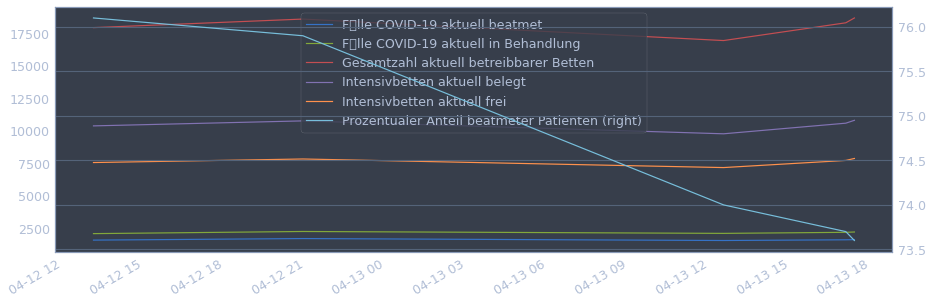

In [10]:
from jupyterthemes import jtplot

jtplot.style(theme='onedork')

totals.plot(secondary_y=totals.columns[5], figsize=(15,5))